# Эксперименты над подходами к стратификации и методами сэмплирования из каждой страты из раздела 1 отчета о НИР.

Во всех экспреиментах ниже при подсчете дисперсии стратифицированной оценки по формуле Горвица-Томпсона мы используем оценку дисперсии, посчитанную по выбранным элементам из страты, однако все эксперименты и выводы также верны, если в качестве оценки дисперсии использовать дисперсию всей страты.

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
from tqdm import tqdm
from scipy.stats import chi2_contingency, kstest, ks_2samp, ttest_ind
from scipy.sparse import issparse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import silhouette_score 


import warnings
warnings.filterwarnings('ignore')

In [151]:
import scipy
from sklearn.cluster import DBSCAN, KMeans
#библиотека kmodes скопирована в папку kmodes в корневой директории проекта
from kmodes.kprototypes import KPrototypes
from scipy.spatial import distance_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [85]:
"""
Функциональность ниже скопирована из открытой библиотеки gower, подробная информация доступна по ссылке 
https://pypi.org/project/gower/
"""
def gower_matrix(data_x, data_y=None, weight=None, cat_features=None):  
    # function checks
    X = data_x
    if data_y is None: Y = data_x 
    else: Y = data_y 
    if not isinstance(X, np.ndarray): 
        if not np.array_equal(X.columns, Y.columns): raise TypeError("X and Y must have same columns!")   
    else: 
         if not X.shape[1] == Y.shape[1]: raise TypeError("X and Y must have same y-dim!")  
                
    if issparse(X) or issparse(Y): raise TypeError("Sparse matrices are not supported!")        
            
    x_n_rows, x_n_cols = X.shape
    y_n_rows, y_n_cols = Y.shape 
    
    if cat_features is None:
        if not isinstance(X, np.ndarray): 
            is_number = np.vectorize(lambda x: not np.issubdtype(x, np.number))
            cat_features = is_number(X.dtypes)    
        else:
            cat_features = np.zeros(x_n_cols, dtype=bool)
            for col in range(x_n_cols):
                if not np.issubdtype(type(X[0, col]), np.number):
                    cat_features[col]=True
    else:          
        cat_features = np.array(cat_features)
    
    # print(cat_features)
    
    if not isinstance(X, np.ndarray): X = np.asarray(X)
    if not isinstance(Y, np.ndarray): Y = np.asarray(Y)
    
    Z = np.concatenate((X,Y))
    
    x_index = range(0,x_n_rows)
    y_index = range(x_n_rows,x_n_rows+y_n_rows)
    
    Z_num = Z[:,np.logical_not(cat_features)]
    
    num_cols = Z_num.shape[1]
    num_ranges = np.zeros(num_cols)
    num_max = np.zeros(num_cols)
    
    for col in range(num_cols):
        col_array = Z_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        num_max[col] = max
        num_ranges[col] = np.abs(1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    Z_num = np.divide(Z_num ,num_max,out=np.zeros_like(Z_num), where=num_max!=0)
    Z_cat = Z[:,cat_features]
    
    if weight is None:
        weight = np.ones(Z.shape[1])
        
    #print(weight)    
    
    weight_cat=weight[cat_features]
    weight_num=weight[np.logical_not(cat_features)]   
        
    out = np.zeros((x_n_rows, y_n_rows), dtype=np.float32)
        
    weight_sum = weight.sum()
    
    X_cat = Z_cat[x_index,]
    X_num = Z_num[x_index,]
    Y_cat = Z_cat[y_index,]
    Y_num = Z_num[y_index,]
    
   # print(X_cat,X_num,Y_cat,Y_num)
    
    for i in range(x_n_rows):          
        j_start= i        
        if x_n_rows != y_n_rows:
            j_start = 0
        # call the main function
        res = gower_get(X_cat[i,:], 
                          X_num[i,:],
                          Y_cat[j_start:y_n_rows,:],
                          Y_num[j_start:y_n_rows,:],
                          weight_cat,
                          weight_num,
                          weight_sum,
                          cat_features,
                          num_ranges,
                          num_max) 
        #print(res)
        out[i,j_start:]=res
        if x_n_rows == y_n_rows: out[i:,j_start]=res
        
    return out


def gower_get(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,
              feature_weight_num,feature_weight_sum,categorical_features,
              ranges_of_numeric,max_of_numeric ):
    
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute(xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    
    return sum_sij

def smallest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    #n += 1
    flat = np.nan_to_num(ary.flatten(), nan=999)
    indices = np.argpartition(-flat, -n)[-n:]
    indices = indices[np.argsort(flat[indices])]
    #indices = np.delete(indices,0,0)
    values = flat[indices]
    return {'index': indices, 'values': values}

def gower_topn(data_x, data_y=None, weight=None, cat_features=None, n = 5):
    
    if data_x.shape[0] >= 2: TypeError("Only support `data_x` of 1 row. ")  
    dm = gower_matrix(data_x, data_y, weight, cat_features)
          
    return smallest_indices(np.nan_to_num(dm[0], nan=1),n)

# Код стратификации Индустриального Партнера

Код стратификации на основе квантильного разбиения из раздела 1.3 отчет.

In [86]:
def get_strats(df, df_aa, p_key:str, part = 2):  
    """
    За основу взяли функцию true_strat. Данная функция возвращает разбиение данных на страты.
    """   
    ERR=0
    flag_group = 0
    mes = ""
    
        
    if(p_key not in df.columns):
        ERR = 1
        mes = "ОШИБКА: В данных не найден столбец содержащий объекты деления!"
        
    elif(len(df.columns)<2):  
        ERR = 2
        mes = "ОШИБКА: Не найдены столбцы с критериями однородности!"
        
    elif(df[p_key].duplicated().any() == True):   
        ERR = 3
        mes = "ОШИБКА: В ключевом столбце найдены дубликаты! Значения должны быть уникальными."
        

    if(ERR > 0): # Если есть ошибки, то запуск деления не возможен    
        
        print(mes)
        
        return ERR
        
    else:
        
        df = sorting_features(df_res = df, p_key = p_key) # сортируем фичи по типу, чистим данные
    
        form_strat_ = form_strat(df, part) # формируем страты
        return form_strat_

In [87]:
# ВЕРХНЕУРОВНЕВЫЙ СКРИПТ

"""
Функция скрипта: верхнеуровневый скрипт, вызывает вспомогательные рабочие скрипты для стратификации, репрезентативного отбора и деления на группы, сохраняет данные.

Входные параметры скрипта:
df - данные, формат – таблица,
part - количество групп, формат – целые числа, в MVP0 значение всегда 2.
p_key – название ключевого столбца, формат - строковый
n – целевое количество участников в выборке, формат - целые числа. 
Если не планируется репрезентативный отбор, то n – это минимальный размер выборки. 
Если репрезентативный отбор планируется, то n, желаемый размер выборки, но он должен быть не меньше минимального размера.
max_num_of_iter – количество попыток найти однородность, формат – числовой, по умолчанию = 1000
alpha – уровень значимости, формат – дробное число, по умолчанию 0.05
representative – флаг репрезентативного отбора, если True, то репрезентативный отбор производится.

На выходе скрипта:

Таблица df_res_all_strat.
+ csv файлы: 

Сохраняется таблица с данными по фичам df_res_all_strat, с именем 'result_all_features.csv'

Сохраняются данные по участникам и группам, под именем 'result.csv'. (При этом остальные столбцы у таблицы df_res_all_strat отбрасываются.)

Сохраняются данные с отчетом о проверке однородности df_report  под именем 'report.csv'.

"""

def true_strat(df, df_aa, p_key:str, n:int, part = 2, max_num_of_iter = 1000, alpha= 0.1, representative = True, name_table='', strat_sample='orig'):  
    
        
    ERR=0
    flag_group = 0
    mes = ""
    
        
    if(p_key not in df.columns):
        ERR = 1
        mes = "ОШИБКА: В данных не найден столбец содержащий объекты деления!"
        
    elif(len(df.columns)<2):  
        ERR = 2
        mes = "ОШИБКА: Не найдены столбцы с критериями однородности!"
        
    elif(df[p_key].duplicated().any() == True):   
        ERR = 3
        mes = "ОШИБКА: В ключевом столбце найдены дубликаты! Значения должны быть уникальными."
        
    elif(len(df)<n):   
        ERR = 4
        mes = "ОШИБКА: В количество участников в таргете меньше, чем целевое количество участников теста."    
        

    if(ERR > 0): # Если есть ошибки, то запуск деления не возможен    
        
        print(mes)
        
        return ERR
        
    else:
        
        df = sorting_features(df_res = df, p_key = p_key) # сортируем фичи по типу, чистим данные

        #######
        
        print("Общее количество участников ГС",len(df), "Репрезентативное количество участников:",n)
        print("\n")
    
        form_strat_ = form_strat(df, part) # формируем страты
         
        small_strats_users = []

        for m in range(max_num_of_iter): 
            
            #print('Итерация:', m+1)
            
            df_res_all_strat = pd.DataFrame()

            for i in form_strat_:    # производим операции над каждой стратой
#                 print("Участники страты",form_strat_[i])
                
                df_strat = df[df[p_key].astype(int).isin(form_strat_[i])]
                
#                 df_strat = df.iloc[form_strat_[i]] # выбор отдельных участников страты 
                
                if df_strat.shape[0] < part:
                    small_strats_users.extend(form_strat_[i])
                    
#                 print(df_strat)
                #df_strat['strat_name'] = i 
            
                if(representative == True): # производим репрезентативный отбор, если он нужен.
                               
                    df_strat = select_prop(df_strat, len(df), n, part)

            
                      
                # делим страту на группы
                df_res = find_group(df_strat, part)
#                 print(df_res.shape)
#                 print(df_res)
    
    
    
                df_res_all_strat = pd.concat([df_res, df_res_all_strat], ignore_index=True) # обеденяем новые данные по всем стратам
            # ключевой столбец назначаем индексом
            return df_res_all_strat
            df_res_all_strat = df_res_all_strat.sort_values(by= p_key, inplace=False)
            df_res_all_strat = df_res_all_strat.astype({p_key: "str"})
            df_res_all_strat = df_res_all_strat.set_index(p_key)
            
            
            
            # убарли юзеров попавших в старты размера < part 
            df_aa = df_aa[~df_aa[p_key].astype(int).isin(small_strats_users)] 
            
            
            # аа-тест
            flag_aa, df_report_aa, df_aa_res = aa_test(df_aa, df_res_all_strat, p_key, part, alpha, representative) 
             
            # проверка однородности      
            flag_checking_uniformity, df_report_test = checking_uniformity(df_res_all_strat,p_group = "group_num",part = part, alpha = alpha)
            #print(df_report_test)  
            
           
            if(flag_checking_uniformity == 1 and len(df_res_all_strat) >= n and flag_aa == 1): #  найдена однородность всех групп

        
                # сохраняем данные по всем фичам
       
                df_res_all_strat.to_csv(f'result_all_features_{k}.csv', sep=';', encoding='utf-8-sig')
        
        
                # сохраняем данные по группам
        
                df_res_all_strat = df_res_all_strat[['group_num']]
        
                df_res_all_strat.to_csv(f'result_{name_table}.csv', sep=';', encoding='utf-8-sig')
            
                print("\n","В КГ:",len(df_res_all_strat[(df_res_all_strat["group_num"] == 0)]), "В ЦГ", len(df_res_all_strat[(df_res_all_strat["group_num"] == 1)]))
    
                print("\n")
        
                # сохраняем данные по однородности
        
                df_report_test.to_csv(f'report_{name_table}.csv', sep=';', encoding='utf-8-sig')
                print("Проверка однородности:",'\n',df_report_test)
                print('\n')
            
                # сохраняем данные по АА-тесту
                
                df_aa_res.to_csv(f'result_aa_{name_table}.csv', sep=';', encoding='utf-8-sig')
            
                df_report_aa.to_csv(f'report_aa_{name_table}.csv', sep=';', encoding='utf-8-sig')
            
                print("AA-тест:",'\n',df_report_aa)
        
                return df_res_all_strat
    
        else:
            
            if(m == max_num_of_iter):
                ERR = 5
                mes = "Однородность на найдена! Замените таргет или измените\уменьшите признаки стратификации."            
                print(mes)
                print("AA:",df_report_aa)
                
                return ERR

## Формирование страт

In [88]:
# Формирование страт
"""
Функция скрипта:  формирование страт.

Входящие параметры: 
df – таблица с данными по участникам
part - количество групп, формат – целые числа, в MVP0 значение всегда 2

"""
    
def form_strat(df, part):
    
    features = []
    strat_feature = []
    
    # features_strat = ['CUSTOMER_TYPE : xi2', 'ACC_BALANCE_RUR : ks', 'CHEP : ks', 'SALES : ks','REGISTRATION_DT : ks']
    features_strat = ['Education : xi2', 'ApplicantIncome : ks','LoanAmount : ks']
 # Список фичей по которым будем стратифицировать #Внимание! список с флагами критериев
    
    kombo={}
    strat_kombo = {}
    strat = {}
    
    for i in df.columns:  
        if(i in features_strat):
            if('ks' in i):
                df[i.replace('ks', 'interval')] = interval_combo(df[i]) # формируем интервалы из числовых фичей
                features.append(i.replace('ks', 'interval'))
            else:
                features.append(i)   
# группируем данные
    for i in features:          
        strat_feature.append({i:df.groupby(i).groups})


    for i in strat_feature:
        for k in i:        
        
            iloc={}
        
            kombo[k] = iloc
        
            for j in i[k]:        
            
                iloc[k+"_"+str(j)] = list(i[k][j])


    for q in range(len(features)):
        
        if(q == 0):
            col_unic = kombo[features[q]]
        else: 
            col_unic = strat
    
        if(q+1<len(features)):
            strat = {}
    
            for e in col_unic:
            
                for r in kombo[features[q+1]]:
                    cells_strat = list(set(col_unic[e]) & set(kombo[features[q+1]][r]))
                    

                    
                    #print("Последний столбец:",features[q])
                    if(q == len(features)-2):
                        #print("Последний столбец:",features[q])
                        if(len(cells_strat)>0): # если страта не пустая \ больше или равна кол-ву групп, записываем участников
                            
                            if(len(cells_strat)<part):
                                if("one_strat" not in strat):
                                    strat["one_strat"] = cells_strat
                                else:    
                                    strat["one_strat"].append(cells_strat[0])
                            #elif(len(cells_strat)==3 and part == 2):
                               # strat[(str(e)+"__"+str(r)).replace(" : xi2", "")] = cells_strat[:2]
                               # if("one_strat" not in strat):
                                    #strat["one_strat"] = cells_strat[2]
                                #else:    
                                    #strat["one_strat"].append(cells_strat[2])
                                #print("\n","Три участника страты:", strat[(str(e)+"__"+str(r)).replace(" : xi2", "")], cells_strat[:2])
                      #print("Нормальная страта:", (str(e)+"__"+str(r)).replace(" : xi2", ""))
                            else:
                                strat[(str(e)+"__"+str(r)).replace(" : xi2", "")] = cells_strat
                        
                    else:    
                        
                        strat[(str(e)+"__"+str(r)).replace(" : xi2", "")] = cells_strat
                        
    if(len(strat)==0):
        strat={'one_strat': list(df.index)}
  
    return strat  



## Отбор числа участников из страты

#### Пропорциональное размещение

Общая сумма участников всех страт - Все участники ГС - находим долю конкретной страты. 

Смотрим, сколько участников теста нам нужно. От этого нового количества n вычисляем n_h то вычисленной доле.

#### Алгорит нахождения кол-ва участников в страте и вычитания из нее необходимого числа.

Правила и исключения

* Страта очень маленькая - ее нужно присоеденить 
* При округлении кол-ва участников страты общиее количество участников теста получилось меньше, чем заявленное из-за погрешности округления - придумать правило 

### Формирование интервалов для числовых фичей

### Метод процентилей

In [89]:
"""
Функция скрипта:  формирование интервалов в числовой фиче.

Входные параметры скрипта:
s – отдельная фича, столбец

На выходе скрипта:

s_percentile, столбец содержащий интервалы для фичи, которая загружалась при вызове скрипта. 

"""

def interval_combo(s):
    
    s_percentile = pd.Series(list(s.values), index=list(s.index)) 
    
    p = [0.5, 0.25, 0.05] 
    
    for i in p:
        s_percentile[list(s[(s<s.quantile(q=i))].index)] = i
        s_percentile[list(s[(s>=s.quantile(q=1.0-i))].index)] = i
        
    s_percentile[list(s[(s == 0)].index)] = 0 # ноль выделяем в отдельный интервал 
    s_percentile[list(s[(s < 0)].index)] = -1 # минусовые значения выделяем в отдельный интервал - т.к. убытки
     
            
    return s_percentile


## Сводный скрипт стратификации

In [90]:
"""
Функция скрипта:  сортировка фичей по критериям + чистка данных в фичах.

Входящие параметры: 
df_res – таблица с данными участников
p_key -  p_key – название ключевого столбца (содержит объекты деления), формат – строковый, 
значение берется из входного параметра p_key скрипта, который вызывает скрипт sorting_features

flag_aa = False - флаг АА-теста, выбор будет ли проводиться АА-тест или стандартная проверка на однородность.

"""

def sorting_features(df_res, p_key:str, flag_aa = False): # сортировка фичей по критериям + чистка данных в фичах
    
    features_ks = ['ApplicantIncome', 'LoanAmount']
    features_xi2 = ['Education']
    features_case = []
    
    list_kriterii=[]

    for i in df_res.columns:  
        
        #print(i,'тип фичи', df_res[i].dtype)
        
        if((i == p_key) or (i == 'group_num') or ("ks" in i) or ("xi2" in i) or ("interval" in i) or ("tt" in i)):
            list_kriterii.append(i)
            
        else:
                    
            if(i in features_xi2):
                #print("Хи2 1", i)
                list_kriterii.append(i+" : xi2")
                
            elif(i in features_ks and (df_res[i].dtype == np.float64 or df_res[i].dtype == np.int64) and flag_aa == False):
                #print("ks", i)
                list_kriterii.append(i+" : ks")
            
            elif(df_res[i].dtype != np.float64 and df_res[i].dtype != np.int64):
                #print("Нужна чистка", i)
                
                # чистка данных в  фиче
                df_res[i] = df_res[i].replace({'null':np.nan, 'Null':np.nan,'NULL':np.nan,'nan':np.nan,'Nan':np.nan,'NaN':np.nan,'NAN':np.nan,'-':np.nan, '':np.nan, ' ':np.nan})          
                
                try:
                    # перевод фичи в числовой формат
                    df_res = df_res.astype({i: "float64"})
                except:  
                    if(i in features_ks or i in features_case):
                        print("Ошибка при переводе в числовой формат фичи:", i, " Данные в фиче не относятся к числовым, требуется замена данных.")
                         
            # анализ данных в фиче, после чистки данных
            
            if(i +" : ks" not in list_kriterii and i+" : xi2" not in list_kriterii and i+" : tt" not in list_kriterii): 
                if(flag_aa == True and (df_res[i].dtype == np.float64 or df_res[i].dtype == np.int64)):
                    list_kriterii.append(i+" : tt")
                
                elif(df_res[i].nunique()>7 and (df_res[i].dtype == np.float64 or df_res[i].dtype == np.int64)):
                        #print("KS", i)                
                        list_kriterii.append(i+" : ks")
                    
                else:
                    #print("Хи2 2", i)
                    list_kriterii.append(i+" : xi2")
                    
    df_res.columns = list_kriterii                
    return df_res

### Проверка однородности - получаем p-value

In [91]:
# скрипт хи2

def ser_conjugacy(ser, index):
    zero=[]        
    index_plus = list(set(index) - set(ser.index.tolist()))
 
    for i in range (len(index_plus)):
        zero.append(0)
    
    return pd.concat([ser, pd.Series(zero, index=index_plus)]) 

"""
Функция скрипта: Построение таблицы сопряженности с учетом малонаполненных подгрупп, проведение стат. теста Хи2.

Входящие параметры: 
gr_A - данные участников по столбцу от одной группы
gr_B - данные участников по столбцу от другой группы


"""

def check_homo_cat_xi2_other(gr_A,gr_B): 
    nonhomo={}
    other={}
    count=0

    # строим таблицу сопряженности
    gr_B=gr_B.groupby(gr_B).count()
    gr_A=gr_A.groupby(gr_A).count()
    index_= pd.Series(gr_B.index.tolist()+gr_A.index.tolist())
    index_= index_.groupby(index_).count().index.tolist()
    
    gr_B = ser_conjugacy(gr_B, index_)
    gr_A = ser_conjugacy(gr_A, index_)    
   
    merge_data=pd.DataFrame()
    merge_data['id_x']=gr_A
    merge_data['id_y']=gr_B
    merge_data=merge_data.fillna(0)     # заполнение пропусков нулями
   
    # Обрабатывем малонаполненные группы
    count_sub_gr=(merge_data['id_x']+merge_data['id_y']).sort_values()    
    
    
    # если есть малонаполненные подгруппы, то объединяем их
    for i in count_sub_gr.index:   
           
        if((count_sub_gr.loc[i]<=15) or (count==1)):
            
            if(count==0):                                          
                other = {'id_x': merge_data['id_x'].loc[i],'id_y':merge_data['id_y'].loc[i]}   
                
            else:  
                other = {'id_x': merge_data['id_x'].loc[i]+other['id_x'],'id_y':merge_data['id_y'].loc[i]+other['id_y']}  
            
            count+=1
            merge_data.drop(labels = [i],axis = 0, inplace = True)                
            
            
    if(len(other)>0):                
            merge_data = pd.concat([merge_data, pd.DataFrame([other],index =['Прочее'])]) # , ignore_index=True
    #print("\n")  
    
          
    pvalue = chi2_contingency(merge_data[["id_x","id_y"]])[1]    
        
    #print('p-value:', round(pvalue,5))    
    if (str(pvalue)=='nan'):       
        
        pvalue = 0
        
    
    return pvalue


In [92]:
# Тест Колмогорова-Смирнова

"""
Функция скрипта: Проведение стат. теста Колмогорова-Смирнова.

Входящие параметры: 
gr_A - данные участников по столбцу от одной группы
gr_B - данные участников по столбцу от другой группы
alpha  –  уровень значимости, формат – дробное число, значение берется из входного параметра alpha  скрипта, который вызывает  скрипт ks_test

"""
def ks_test(gr_A,gr_B,alpha):
    ks_test=ks_2samp(gr_A,gr_B)[1]
    #if(ks_test<alpha):
        #print("Колмогоров-Смирнов, НЕ однородны: р=",ks_test)    
    #else:
        #print("Колмогоров-Смирнов, однородны: р=",ks_test) 
    
    return ks_test
    


In [93]:
"""
Функция скрипта: проверка однородности, формирования отчета по фичам
Входящие параметры: 

•	df_res – таблица сформированная скриптами random_strat или multy_group•	
•	alpha  –  уровень значимости, формат – дробное число, значение берется из входного параметра alpha  скрипта, который вызывает  скрипт checking_uniformity
•	p_group - название столбца с указанием принадлежности к группе таблицы df_res, формат - строковый, если скрипт вызывается скрипами random_strat или multy_group, значение «».
•	part -  количество групп, формат – целые числа, значение берется из входного параметра part скрипта, который вызывает скрипт checking_uniformity
"""

def checking_uniformity(df_res, p_group:str, part, alpha):
    flag_group=0      

    
    df_report = pd.DataFrame()    
    df_report_new  = pd.DataFrame()
    
    
    for i in df_res.columns:   
                        
        if('Unnamed' in i):                
            df_res.drop(i, axis=1, inplace=True)
            
        elif(('xi2' in i) or ('ks' in i) or ('tt' in i)):
                        
            
#####################################################################################################3                        
               
                        # проверка на две группы  
            if(part==2):
                #print("две группы")
                        
                gr_A=df_res[(df_res["group_num"] == 0 )][i] 
                gr_B=df_res[(df_res["group_num"] == 1 )][i]                         
                        
                    # если распределение биноминальное или категориальное - отправляем на хи2, кат - не более 7 уникальзых значений. 
                
                
                
                if('xi2' in i):
                            
                    #print("бином или категория", i, df_res[i].dtypes)  #фича на хи2                    
                    p_value = check_homo_cat_xi2_other(gr_A,gr_B)
                    #res=[i,p_value,alpha] 
                    
                        #break  
                            
                            
                elif('ks' in i):     
                    # числовые отправляются на критерий Колмогорова-Смирнова
                    #print("колмогоров", i, df_res[i].dtypes)  
                    
                    p_value = ks_test(gr_A,gr_B,alpha) 
                    #res=[i,p_value,alpha] 
                     # Заполняем данными по итерации датафрейм сплитовалки  
                elif('tt' in i):   
                    
                    p_value = t_test(gr_A,gr_B, alpha)
                    
                        #break #если однородность не найдена на одной из колонок, следующие не проверяются, переход к следующей итерации
            # если нет однородности
                
                if(p_value < alpha):                        
                    flag = 0  
                else:
                    flag = 1
                    
            df_report_new = pd.DataFrame({'features':i, 'p-value':p_value, 'alpha':alpha, 'flag':flag},index = [0])
        
            df_report = pd.concat([df_report, df_report_new], ignore_index=True)
                        
    
    if(df_report['flag'].nunique()==1 and df_report['flag'].unique()==1):
        flag_group = 1 
    #print("Флаг однородности:", flag_group)
    
    # flag_group = 1, значит однородно
    return flag_group, df_report 
 

### Отбор и деление

In [94]:
# деление на группы

"""
Функция скрипта: деление на группы 

Входящие параметры: 
df - данные по участникам страты, формат – таблица,
part - количество групп, формат – целые числа.

"""
def find_group(df,part:int):        
    
    df_new = pd.DataFrame()
    df_res = pd.DataFrame()
    
    if(len(df)>0):
        n_h = len(df)
        df.reset_index(drop=True, inplace=True) # сбрасываем индексы
        n_h_group = round(n_h/part)
        
        if(n_h_group > 0):
            for i in range(part):          
            
                if(i!=(part-1)): 
                
                                   
                        df_new=df.sample(n=n_h_group)             
                        df=df[~df.index.isin(df_new.index)]  
            
                else:    
                    df_new=df
            
        
                df_new['group_num']=i    
                df_res = pd.concat([df_res, df_new], ignore_index=True) #
        
        
    return df_res   

In [95]:
"""
Функция скрипта: При репрезентативном отборе пропорционально вычисляет размер страты для тестовой выборки.

Входящие параметры: 
df_strat – данные по участникам страты, формат – таблица
n_gs – количество участников в ГС, формат - целые числа
n – количество участников в выборке, формат - целые числа
part - количество групп, формат – целые числа, в MVP0 значение всегда 2.

"""

def select_prop(df_strat, n_gs:int, n:int, part:int):
    
    per_strat = len(df_strat)/n_gs # находим процент, занимаемый стратой в ГС
        
    
    n_h =  round(n*per_strat) 
    if(n_h > 0 and n_h < part):
        n_h = part # отрез участников для малых страт    
        
    if(part == 2 and n_h==3):
        n_h = 2
        
       # рандомно выбераем из страты нужное кол-во участников в выборку
    if(n_h > 0):       
        df_strat = df_strat.sample(n=n_h) 
    else:
        df_strat = pd.DataFrame()

        
    return df_strat
 

In [96]:
"""
Входные параметры скрипта:
gr_A - данные участников по столбцу от одной группы
gr_B - данные участников по столбцу от другой группы
alpha  –  уровень значимости, формат – дробное число, значение берется из входного параметра alpha  скрипта, который вызывает  скрипт ks_test

"""

def t_test(gr_A,gr_B, alpha):
    
    # t-тест с разными дисперсиями модификация Уэлша
    stat, p_value = ttest_ind(gr_A, gr_B, equal_var=False)[:2]  
    #if(p_value<alpha):
        #print("t-test, НЕ однородны: р=",ks_test)    
    #else:
        #print("t-test, однородны: р=",ks_test) 
    return  p_value 
    

In [97]:
"""
Входные параметры скрипта:
df_aa - данные включающие ключевой столбец идентичный таблице df и фичи для проведения АА-теста, формат – таблица;
df – данные включающие ключевой столбец и фичи с признаками однородности, формат – таблица;
part - количество групп, формат – целые числа, в MVP0 значение всегда 2.
p_key – название ключевого столбца, формат - строковый
alpha – уровень значимости, формат – дробное число, по умолчанию 0.05
representative – флаг репрезентативного отбора, если True, то репрезентативный отбор производится.

"""

def aa_test(df_aa, df, p_key:str ,part:int, alpha:float, representative:bool):
    
    #print('Колонки датасета АА -аа',df_aa.columns)
    
    df = df[['group_num']]
    df_aa = df_aa.sort_values(by = p_key, inplace=False)  
    df_aa = df_aa.astype({p_key: "str"})
    df_aa = df_aa.set_index(p_key)
        
    # Если есть репрезентативный отбор
    if(representative == True):
   
        df_aa=df_aa[df_aa.index.isin(df.index)] 
    #
    df_aa["group_num"] = df["group_num"].values
    
    # чистим данные
    df_aa = sorting_features(df_aa, p_key, True)
    
    
    # проверка однородности      
    flag_aa, df_report_test_aa = checking_uniformity(df_aa, p_group = "group_num", part = part, alpha = alpha)
   
    #print('df',"\n", df.head())
    #print("\n")
    #print('df_aa',"\n",df_aa.head())
    #print("\n")  
    if(len(df) == len(df_aa)):
        
        return flag_aa, df_report_test_aa, df_aa
    

# Оптимальные пропорции при сэмплировании из страт

Пусть задана конечная генеральная совокупность $(X_i,Y_i)_{i=1}^{N}$ объема $N$, где $X_i \in \mathbb{R}^{d}$ - набор признаков $i$-го объекта, а $Y_i$ - соответствующая целевая метрика. Мы рассматриваем задачу оценки среднего значения конечной генеральной совокупности $\bar{Y} = N^{-1} \sum\limits_{i = 1}^N Y_i$ по выборке $\{Y_i : i \in S\}$ размера $n < N$. Пускай есть разбиение на объектов из матрицы $X$ на страты $B_1,..,B_H$ размером $N_1,..,N_H$, так что $\sum_{h=1}^{H}N_h = N$.

Для проведения простого $A/B$-теста нам необходимо сгенерировать две группы пользователей, размером n, таким образом, что из каждой страты $h\in\{1,..,H\}$ берется по $n_h$ элементов. В этом случае дисперсия стратифицированной оценки $\hat{Y}^{(strat)}$, вычисляемая по формуле Горвица-Томпсона, имеет вид 
$$
\begin{equation}
Var[\hat{Y}^{(strat)}] = \frac{1}{N^2}\sum_{h=1}^{H} N_h^2 \left(1 - \frac{n_h}{N_h}\right)\frac{S_h^2}{n_h}\,.
\end{equation}
$$

Подходов к выбору $n_1,\dots, n_H$ существует много, мы рассмотрим два наиболее часто используемых из них, описанные в разделе 1.2 отчета: пропорциональное сэмплирование, при котором $n_i =  \left[\dfrac{nN_i}{N}\right]$, где $[x]$ обозначает операцию взятия целой части, и сэмплирование с учетом дисперсии, когда $n_i = \dfrac{S_i^2 N_i n}{\sum\limits_{j=1}^H S^2_j N_j}$, где $S_i~-~$дисперсия $i-$ой страты

## Эксперимент на данных о займах (data/load_data_set.csv), описанный в разделе 1.2.2 отчета

In [98]:
## Скачать датасет можно поссылке https://www.kaggle.com/datasets/burak3ergun/loan-data-set/
df = pd.read_csv("data/loan_data_set.csv", sep=';')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Обработка признаков датасета

#### Gender

Удалим строки с пустым значением признака и каждое уникальное значение категории заменим на число

In [99]:
df.dropna(subset=['Gender'], inplace=True)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0.0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3.0,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1.0,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2.0,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


#### LoanAmount

Заполним пустые значение медианой

In [100]:
df.loc[df['LoanAmount'].isna(), 'LoanAmount'] = df.loc[~df['LoanAmount'].isna(), 'LoanAmount'].median()

#### Бинарные признаки

Рассмотрим зависимость суммы кредита от дохода заявителя при разных значениях бинарных признаков.

Каждое уникальное значение категории в бинарных признаках заменим на число

In [101]:
binary_columns = ["Gender", "Married", "Education", 'Credit_History', 'Property_Area']

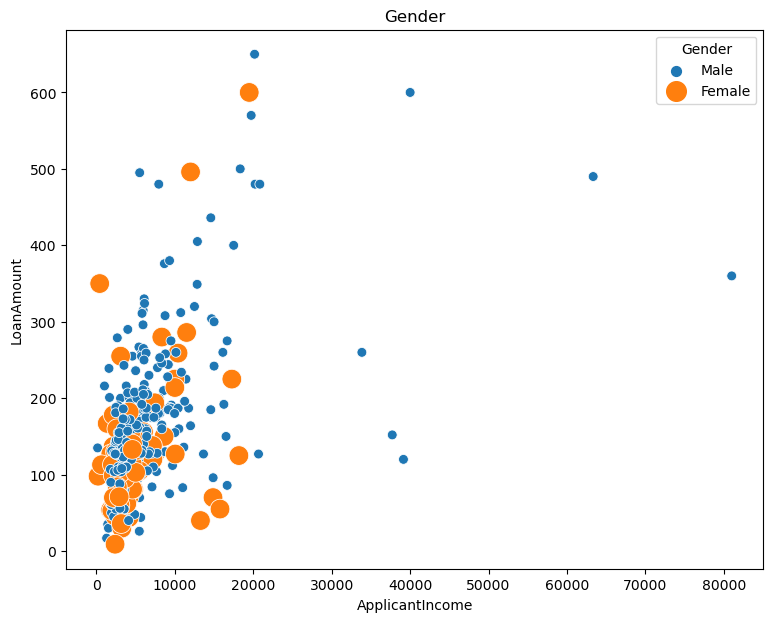

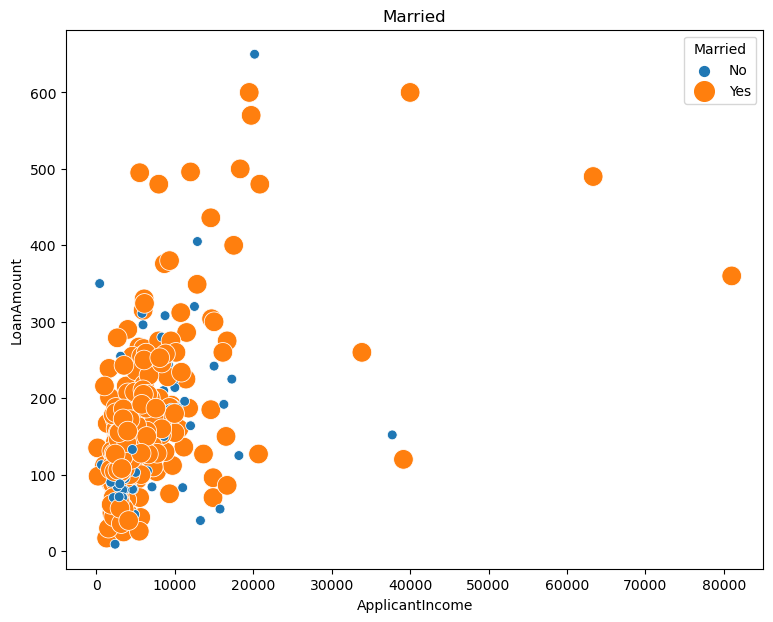

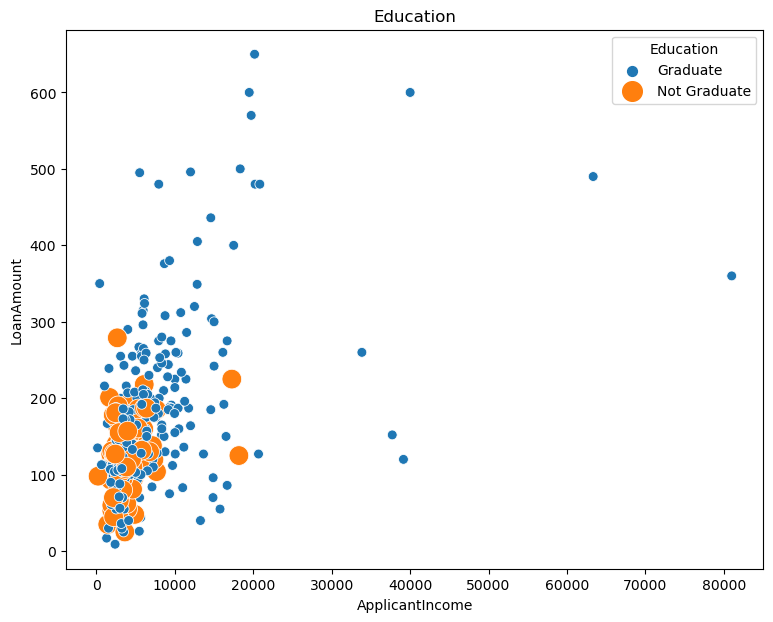

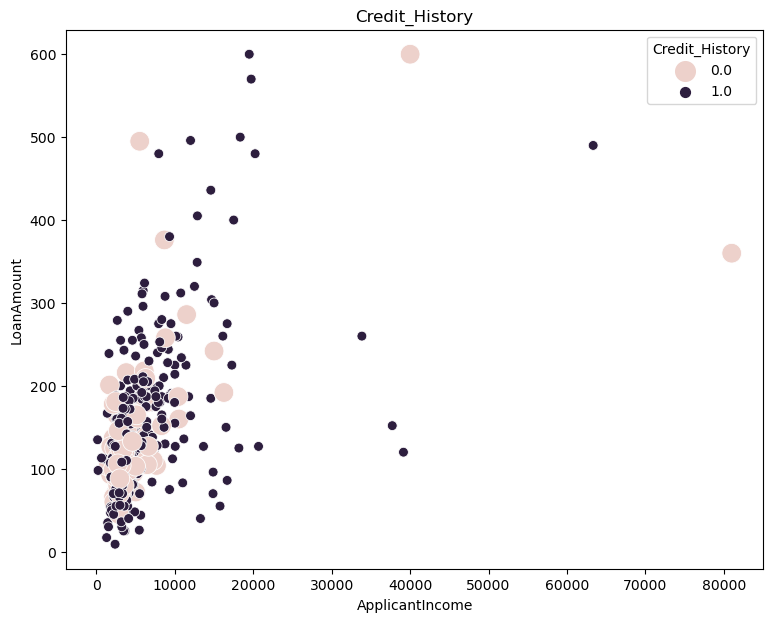

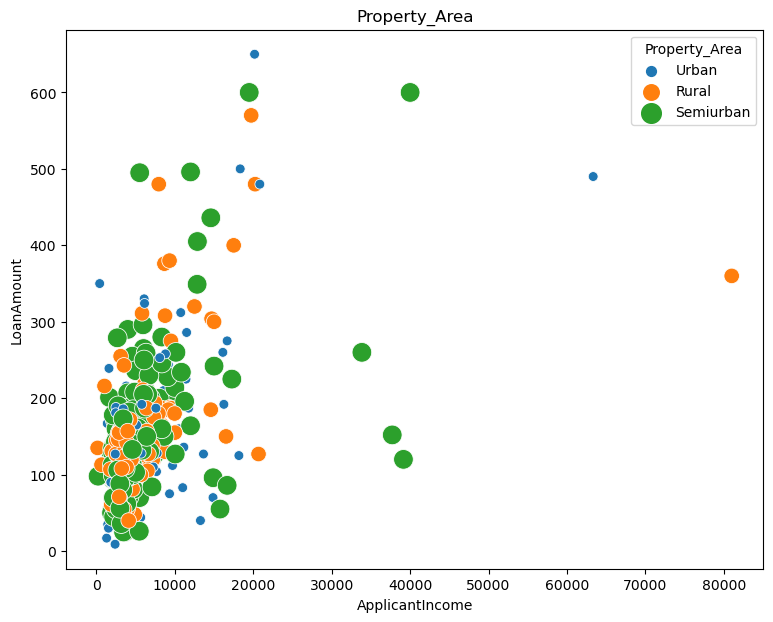

In [102]:
plt.rcParams["figure.figsize"] = (9,7)
for column in binary_columns:
    sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount', hue=column, size=column, sizes=(200, 50))
    plt.title(column)
    plt.show()

In [103]:
df.loc[df['Gender'] == "Male", "Gender"] = 0
df.loc[df['Gender'] == "Female", "Gender"] = 1

df.loc[df['Education'] == "Not Graduate", "Education"] = 0
df.loc[df['Education'] == "Graduate", "Education"] = 1

df.loc[df['Loan_Status'] == "N", "Loan_Status"] = 0
df.loc[df['Loan_Status'] == "Y", "Loan_Status"] = 1

#### ApplicantIncome

Переведем в формат float

In [104]:
df['ApplicantIncome'] = df['ApplicantIncome'].astype(float)

In [105]:
df['ID'] = df.index
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ID
0,LP001002,0,No,0.0,1,No,5849.0,0.0,127.0,360.0,1.0,Urban,1,0
1,LP001003,0,Yes,1.0,1,No,4583.0,1508.0,128.0,360.0,1.0,Rural,0,1
2,LP001005,0,Yes,0.0,1,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,1,2
3,LP001006,0,Yes,0.0,0,No,2583.0,2358.0,120.0,360.0,1.0,Urban,1,3
4,LP001008,0,No,0.0,1,No,6000.0,0.0,141.0,360.0,1.0,Urban,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,1,No,0.0,1,No,2900.0,0.0,71.0,360.0,1.0,Rural,1,609
610,LP002979,0,Yes,3.0,1,No,4106.0,0.0,40.0,180.0,1.0,Rural,1,610
611,LP002983,0,Yes,1.0,1,No,8072.0,240.0,253.0,360.0,1.0,Urban,1,611
612,LP002984,0,Yes,2.0,1,No,7583.0,0.0,187.0,360.0,1.0,Urban,1,612


In [106]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'ID'],
      dtype='object')

In [107]:
cat_features = ['Gender', 'Education']
num_features = ['ApplicantIncome', 'LoanAmount']

In [108]:
# Отобрали признаки, по которым будем проводить стратификацию 

strat_features = ['Gender', 'Education', 'ApplicantIncome', 'LoanAmount']

In [109]:
df_inp = df[['ID'] + strat_features]
df_aa = df[['ID', 'Loan_Status']]

In [110]:
TOTAL_SIZE = df_inp.shape[0]
P_KEY = "ID"
TARGET_COLUMN = "Loan_Status"

def calc_variance(values, N_h, n_h):
    """
    Функция для подсчета дисперсии по формуле Горвица-Томпсона внутри одной страты
    Параметры:
        values - array - массив со значениями целевой метрики для данной страты
        N_h - int - размер данной страты
        n_h - int - число элементов для сэмплирования
    Выход:
        var - float - дисперсия Горвица-Томпсона внутри данной страты
    """
    var = 0
    if len(values) > 1:
        var = values.var(ddof=1)
    else:
        return var
    
    if n_h != 0:
        var = N_h ** 2 * (1 - n_h / N_h) * (var / n_h)
    else:
        var = 0
    return var

def calc_strats_var_size(all_strats, target_df):
    """
    Функция для подсчета дисперсии внутри страт и размеров страт

    Параметры:
        all_strats - dict - словарь со стратами и ID пользователей
        target_df - DataFrame - таблица со значением целевой метрики для всех пользователей и их ID
    Выход:
        stds - array[float] - дисперсия каждой страты
        sizes - array[int] -  размер каждой страты
    """
    stds = []
    sizes = []

    for strata in all_strats:
        user_indexes = all_strats[strata]
        target = target_df.loc[target_df[P_KEY].isin(user_indexes), TARGET_COLUMN]
        if len(target) <= 1:
            stds.append(0.0)
        else:
            stds.append(np.std(target, ddof=1))

        sizes.append(len(target))
        
    sizes =  np.array(sizes)
    stds = np.array(stds)

    return stds, sizes


In [111]:
strats = get_strats(df_inp, df_aa, p_key="ID", part=2)

In [112]:
n = 20
TOTAL_SIZE = df_inp.shape[0]

stds, sizes = calc_strats_var_size(strats, df_aa)

# Число элементов из каждой страты при пропорциональном сэмплировании и сэмплировании с учетом дисперсии
n_h = np.round((sizes * stds * n) / np.sum(stds * sizes)).astype(int)
n_h_prop = np.round(n * (sizes / TOTAL_SIZE)).astype(int)


print(n_h, n_h_prop)

j = 0
var_proportional = 0
var_variance_min = 0

for strata in strats:
    all_users_from_strata = strats[strata]
    np.random.seed(2)
    users_proportional = np.random.choice(all_users_from_strata,  n_h_prop[j], replace=False)

    np.random.seed(1)
    users_variance_min = np.random.choice(all_users_from_strata, n_h[j], replace=False)

    N_h = len(all_users_from_strata)


    var_proportional += calc_variance(df_aa.loc[users_proportional, "Loan_Status"], N_h, n_h=n_h_prop[j])
    var_variance_min += calc_variance(df_aa.loc[users_variance_min, "Loan_Status"], N_h, n_h=n_h[j])
    
    j += 1


print(f"Stratified Variance\nSampling proportional: {var_proportional}\tSampling with variance: {var_variance_min}")
    


[0 0 0 0 1 1 0 1 2 1 1 1 1 3 2 0 3 4] [0 0 0 0 1 1 0 0 2 1 1 0 1 3 3 0 3 4]
Stratified Variance
Sampling proportional: 2211.527777777778	Sampling with variance: 1473.75


In [113]:
data = [[var_proportional], [var_variance_min]] 
results = pd.DataFrame(data=data, index=["Пропорциональное", "С учетом дисперсии"], columns=["Стратифицированная дисперсия"])
results.index.name = "Сэмплирование"
results

,Стратифицированная дисперсия
Сэмплирование,
Пропорциональное,2211.527778
С учетом дисперсии,1473.750000


In [114]:
data = [[var_proportional / (np.sum(sizes)**2)], [var_variance_min / (np.sum(sizes)**2)]] 
results = pd.DataFrame(data=data, index=["Пропорциональное", "С учетом дисперсии"], columns=["Стратифицированная дисперсия"])
results.index.name = "Сэмплирование"
results

,Стратифицированная дисперсия
Сэмплирование,
Пропорциональное,0.006123
С учетом дисперсии,0.004080


In [115]:
n = 100
n_h = np.round((sizes * stds * n) / np.sum(stds * sizes)).astype(int)
n_h_prop = np.round((n+2) * (sizes / TOTAL_SIZE)).astype(int)

In [116]:
n_iter = 10_00

all_base_mean = []
all_notbase_mean = []


for i in tqdm(range(n_iter)):
    mean_base = 0
    mean_not_base = 0

    index = 0
    for strata in strats:
        all_users_from_strata = strats[strata]
        
        weight = len(all_users_from_strata) / TOTAL_SIZE

        np.random.seed(11 * i + 1)
        users_proportional = np.random.choice(all_users_from_strata,  n_h_prop[index], replace=False)
        if len(users_proportional) > 0:
            mean_base += weight * df_aa.loc[df_aa["ID"].astype(int).isin(users_proportional), 'Loan_Status'].mean()
        
        np.random.seed(13 * i + 1)
        users_variance_min = np.random.choice(all_users_from_strata, n_h[index], replace=False)
        if len(users_variance_min) > 0:
            mean_not_base += weight * df_aa.loc[df_aa["ID"].astype(int).isin(users_variance_min), 'Loan_Status'].mean()

        index += 1

    all_base_mean.append(mean_base)
    all_notbase_mean.append(mean_not_base)
    


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 235.26it/s]


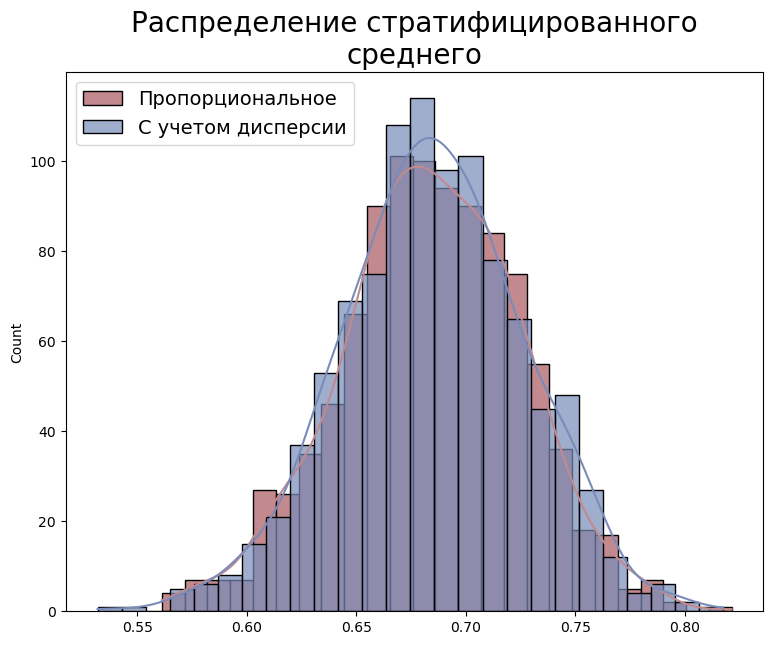

In [117]:
sns.histplot(all_base_mean, kde=True, color="#c2898f", alpha=1, label="Пропорциональное")
sns.histplot(all_notbase_mean, kde=True, color="#788cba", alpha=0.7, label="С учетом дисперсии")
plt.legend(fontsize=14, loc='upper left')
plt.title("Распределение стратифицированного\nсреднего", fontsize=20)
plt.show()

## Эксперимент на синтетических данных, описанный в разделе 1.2.1 отчета

In [118]:
mu = np.zeros(2)
sizes = np.array([700, 200, 100])
sigmas = np.array([1, 1/16, 16])

In [119]:
TOTAL_SIZE = np.sum(sizes)

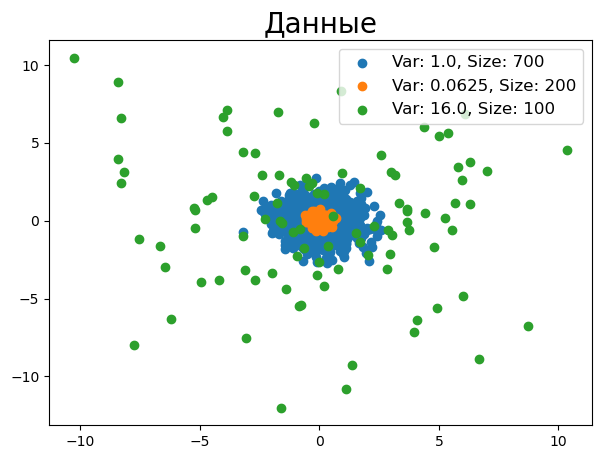

In [120]:
plt.rcParams["figure.figsize"] = (7,5)
datas = np.empty((0,2), float)

for i in range(len(sizes)):
    data = np.random.multivariate_normal(mu, sigmas[i] * np.eye(2), size=sizes[i])
    datas = np.vstack((datas, data))
    plt.scatter(data[:, 0], data[:, 1], label=f'Var: {sigmas[i]}, Size: {sizes[i]}')

plt.title("Данные", fontsize=20)
plt.legend(fontsize=12)
plt.show()

In [121]:
y = datas[:, 0] + datas[:, 1]

In [122]:
ys = []
stds = []

beg = 0
for i in range(len(sizes)):
    stds.append(y[beg: beg + sizes[i]].std(ddof=1))
    ys.append(y[beg: beg + sizes[i]])
    beg = beg + sizes[i]

stds = np.array(stds)


In [123]:
def calc_variance_synthetic(values, N_h, n_h):
    """
    Функция для подсчета дисперсии по формуле Горвица-Томпсона внутри одной страты
    Параметры:
        values - array - массив со значениями целевой метрики для данной страты
        N_h - int - размер данной страты
        n_h - int - число элементов для сэмплирования
    Выход:
        var - float - дисперсия Горвица-Томпсона внутри данной страты
    """
    var = 0
    if len(values) > 1:
        var = values.var(ddof=1)
    else:
        return var
    
    if n_h != 0:
        var = N_h ** 2 * (1 - n_h / N_h) * (var / n_h)
    else:
        var = 0
    return var

In [124]:
# Число элементов из каждой страты при пропорциональном сэмплировании и сэмплировании с учетом дисперсии
n_h = np.round((sizes * stds * n) / np.sum(stds * sizes)).astype(int)
n_h_prop = np.round(n * (sizes / TOTAL_SIZE)).astype(int)

j = 0
var_proportional = 0
var_variance_min = 0


for i in range(0, len(sizes)):
    # np.random.seed(4)
    target_proportional = np.random.choice(ys[i],  n_h_prop[j], replace=False)

    # np.random.seed(1)
    target_variance_min = np.random.choice(ys[i], n_h[j], replace=False)

    N_h = sizes[i]
    
    var_proportional += calc_variance_synthetic(target_proportional, N_h, n_h=n_h_prop[j])
    var_variance_min += calc_variance_synthetic(target_variance_min, N_h, n_h=n_h[j])
    
    j += 1

In [125]:
results = pd.DataFrame(data=[[round(var_proportional, 2)], [round(var_variance_min, 2)]], index=['Пропорциональное', 'С учетом дисперсии'], columns=['Дисперсия'])
results.index.name = 'Сэмплирование'
results

,Дисперсия
Сэмплирование,
Пропорциональное,45757.72
С учетом дисперсии,19091.01


In [126]:
N = np.sum(sizes)
results = pd.DataFrame(data=[[round(var_proportional / (TOTAL_SIZE ** 2), 2)], [round(var_variance_min / (TOTAL_SIZE ** 2), 2)]], index=['Пропорциональное', 'С учетом дисперсии'], columns=['Дисперсия'])
results.index.name = 'Сэмплирование'
results

,Дисперсия
Сэмплирование,
Пропорциональное,0.05
С учетом дисперсии,0.02


In [127]:
n_iter = 10_000
n = 20
n_h = np.round((sizes * stds * n) / np.sum(stds * sizes)).astype(int)
n_h_prop = np.round(n * (sizes / TOTAL_SIZE)).astype(int)


all_base_mean = []
all_notbase_mean = []


for i in tqdm(range(n_iter)):
    mean_base = 0
    mean_not_base = 0

    for j in range(0, 3):
        target = ys[j]
        
        weight = sizes[j] / TOTAL_SIZE

        target_proportional = np.random.choice(target,  n_h_prop[j], replace=False)
        mean_base += weight * target_proportional.mean()
        
        target_variance_min = np.random.choice(target, n_h[j], replace=False)
        mean_not_base += weight * target_variance_min.mean()


    all_base_mean.append(mean_base)
    all_notbase_mean.append(mean_not_base)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 14309.61it/s]


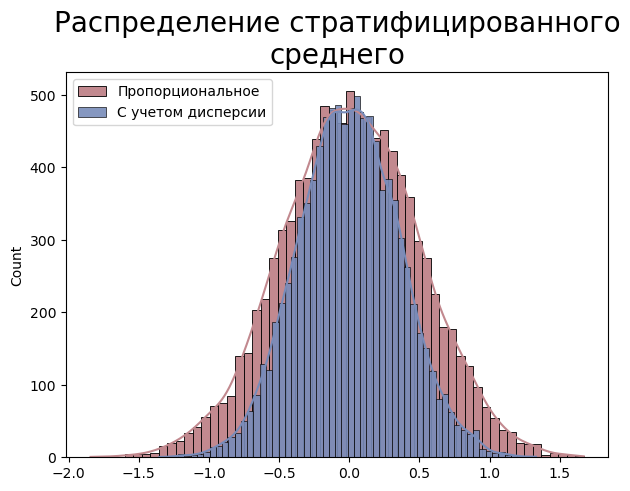

In [128]:
sns.histplot(all_base_mean, kde=True, color="#c2898f", alpha=1, label="Пропорциональное")
sns.histplot(all_notbase_mean, kde=True, color="#788cba", alpha=0.9, label="С учетом дисперсии")
plt.legend(fontsize="medium", loc='upper left')
plt.title("Распределение стратифицированного\nсреднего", fontsize=20)
plt.show()


# Стратификация с использованием алгоритмов кластеризации из раздела 1.4 отчета

До этого мы рассматривали стратификацию на основе квантильного разбиения, однако такой подход зачастую порождает большое число страт, что значительно усложняет процедуру сэмплирования. В данном разделе описываются эксперименты по применению метода стартификации на основе кластеризации.

## Сравнение методов кластеризации на данных о займах (data/loan_data_set.csv)

В данном разделе мы рассмотрели 3 метода кластеризации (DBSCAN, K-Means, K-prototypes), описанные в разделе 1.4 отчета.

In [129]:
def form_strat_cluster(df, algo='DBSCAN', **kwargs):
    """
    Применение алгоримтов кластериазации для формирования страт
    Параметры:
        df - DataFrame - данные о пользователях
        features - str - названия признаков по которым формируем страты
        algo - str - Название алгоримат для кластеризации. Должен быть указано название из sklearn
        **kwargs - содержат параметры для алгоритма кластеризации
    Вызод:
        clustering - обученная модель кластеризации
    """

    X = df
    try:
        clustering = eval(algo)(**kwargs)
        clustering.fit(X)
    except NameError:
        print(f"Неверное название алгоритма")
        return
    
    return clustering

In [130]:
# Пайплайн обработки датасета с использованием One-hot Encoder и Standard Scaler для кодирования категориальных признаков

numerical_encoder = SimpleImputer(strategy="mean")
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
standart_scaller = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, cat_features),
        ("num", standart_scaller, num_features),
    ],
    #verbose_feature_names_out=False,
)

pipe = Pipeline(
    [
        ("preprocess", preprocessing),
    ]
)
df_ohe = pipe.fit_transform(df[strat_features])

In [131]:
# Пайплайн обработки датасета с использованием One-hot Encoder и SimpleImputer для кодирования категориальных признаков

numerical_encoder = SimpleImputer(strategy="mean")
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
standart_scaller = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, cat_features),
        ("num", numerical_encoder, num_features),
    ],
    #verbose_feature_names_out=False,
)

pipe = Pipeline(
    [
        ("preprocess", preprocessing),
    ]
)
df_no_scaler = pipe.fit_transform(df[strat_features])

In [132]:
df_orig = df_ohe[:, [1, 3, 4, 5]]
df_orig

array([[ 0.        ,  1.        ,  0.09534327, -0.21418599],
       [ 0.        ,  1.        , -0.12325262, -0.20184648],
       [ 0.        ,  1.        , -0.39658382, -0.96689615],
       ...,
       [ 0.        ,  1.        ,  0.47918107,  1.34059239],
       [ 0.        ,  1.        ,  0.39474712,  0.52618467],
       [ 1.        ,  1.        , -0.12325262, -0.14014892]])

### DBSCAN

M. Ester, H. Kriegel, J. Sander, X. Xu, et al "A density-based algorithm for discovering clusters in large spatial databases with noise."

In [133]:
eps_range = np.linspace(0.01, 0.25, 8)
min_samples_range = [5, 7, 10]
eps_range

array([0.01      , 0.04428571, 0.07857143, 0.11285714, 0.14714286,
       0.18142857, 0.21571429, 0.25      ])

(601, 2)


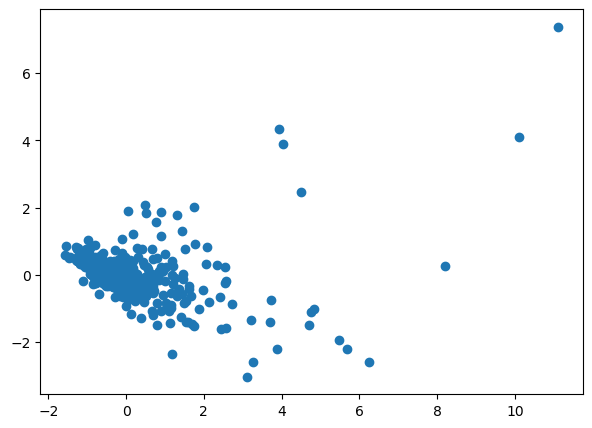

In [134]:
# Применим алгоритм понижаения размерности PCA для отрисовки данных

pca = PCA(n_components=2).fit(df_orig)

X_new = pca.transform(df_orig)
print(X_new.shape)
plt.scatter(X_new[:,0], X_new[:,1])

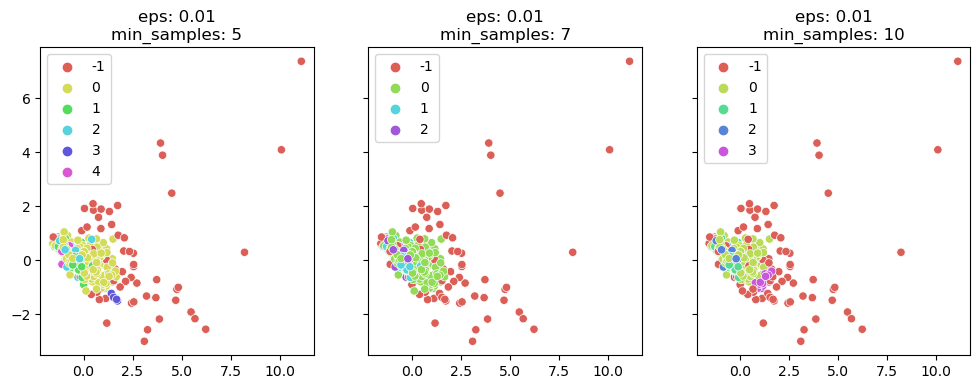

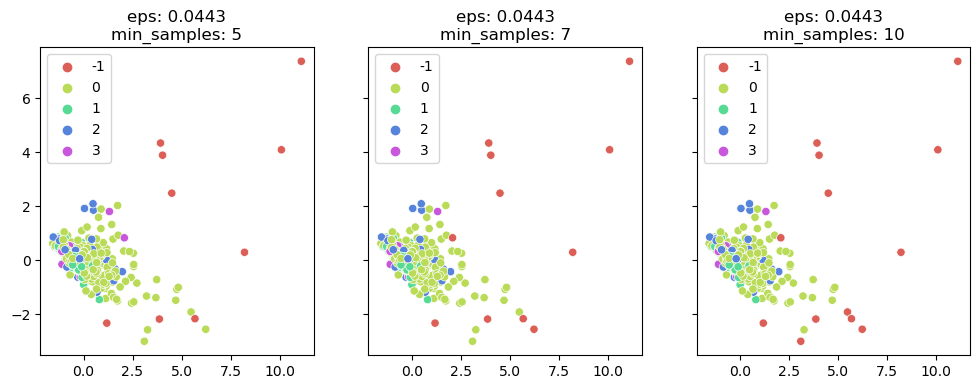

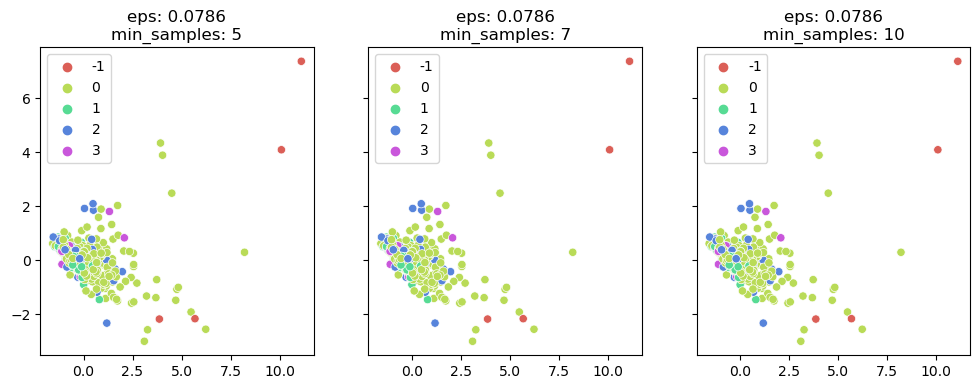

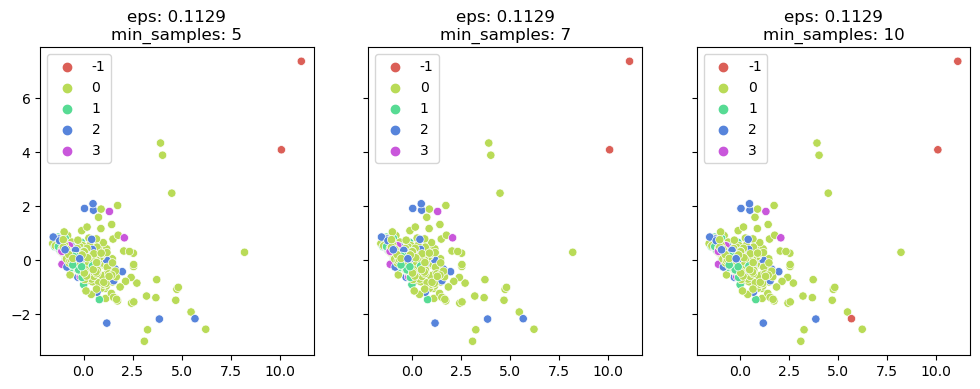

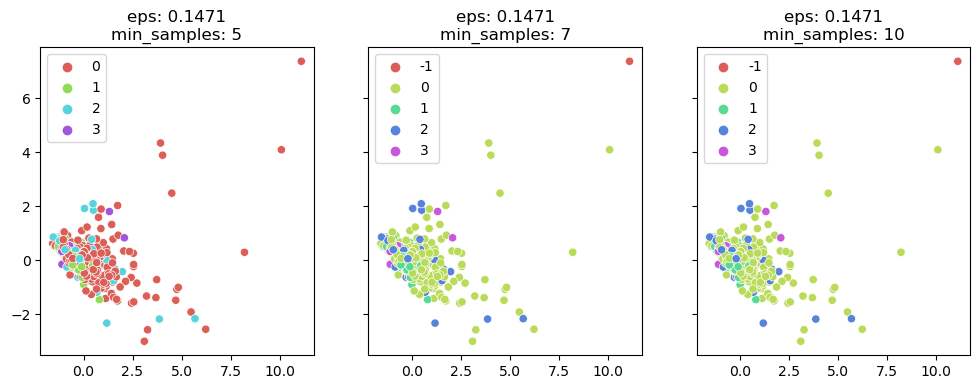

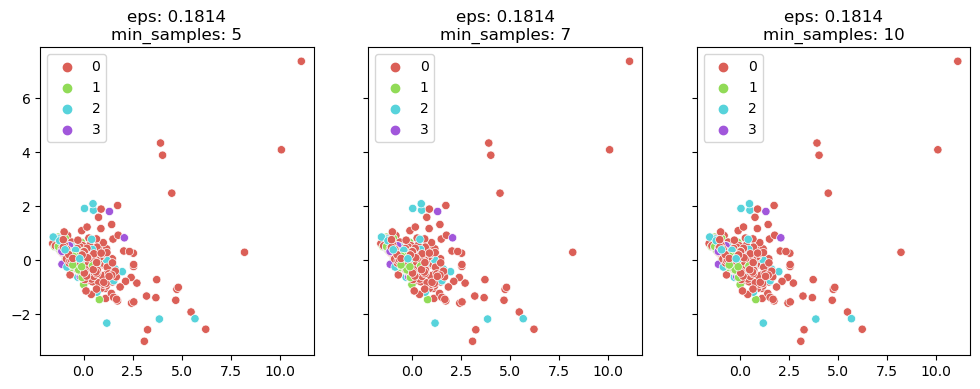

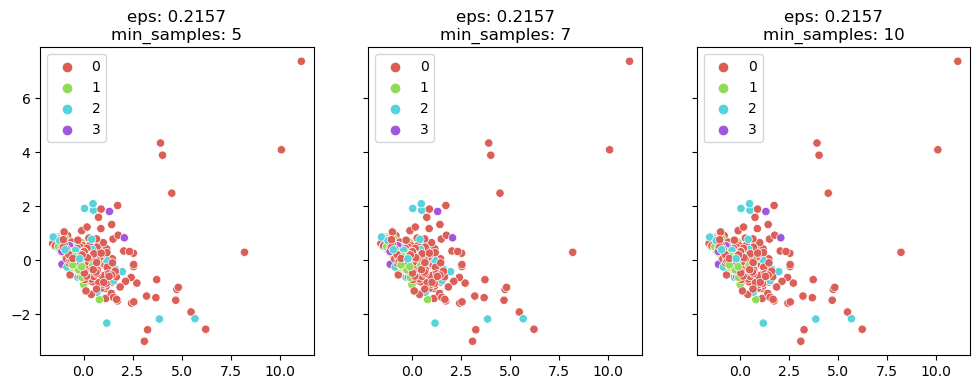

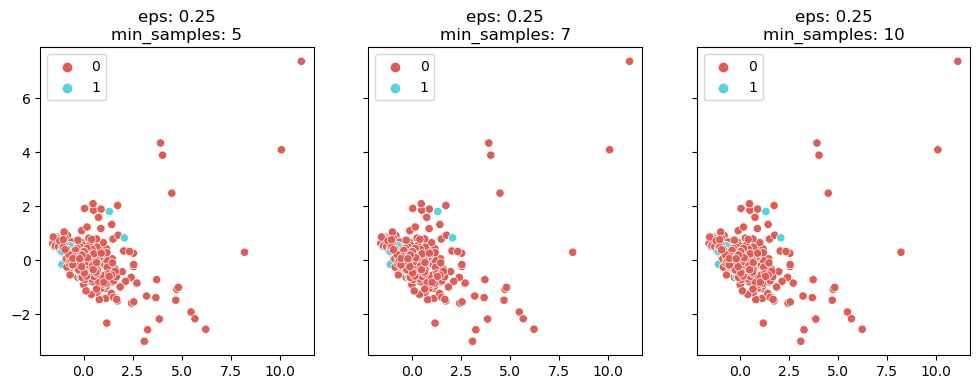

CPU times: user 2.17 s, sys: 51.9 ms, total: 2.22 s
Wall time: 2.23 s


In [135]:
%%time

# DBSCAN с использованием расстояния Говера для учета категориальных признаков

for e in eps_range:
    f, axes = plt.subplots(1, len(min_samples_range), sharey=True,  figsize=(12, 4)) 
    i = 0
    for ms in min_samples_range:
        dist_matrix = gower_matrix(df_orig)
        clust = form_strat_cluster(dist_matrix, algo='DBSCAN', eps=e, min_samples=ms, metric = "precomputed")
        
        sns.scatterplot(x=X_new[:,0], y=X_new[:,1], hue=clust.labels_,\
                        palette=sns.color_palette("hls", len(np.unique(clust.labels_))), ax=axes[i])
        axes[i].set_title(f'eps: {round(e, 4)}\nmin_samples: {ms}')
        i += 1
    plt.show()

In [136]:
eps_range_euclidean = np.linspace(0.5, 2, 8)
eps_range_euclidean

array([0.5       , 0.71428571, 0.92857143, 1.14285714, 1.35714286,
       1.57142857, 1.78571429, 2.        ])

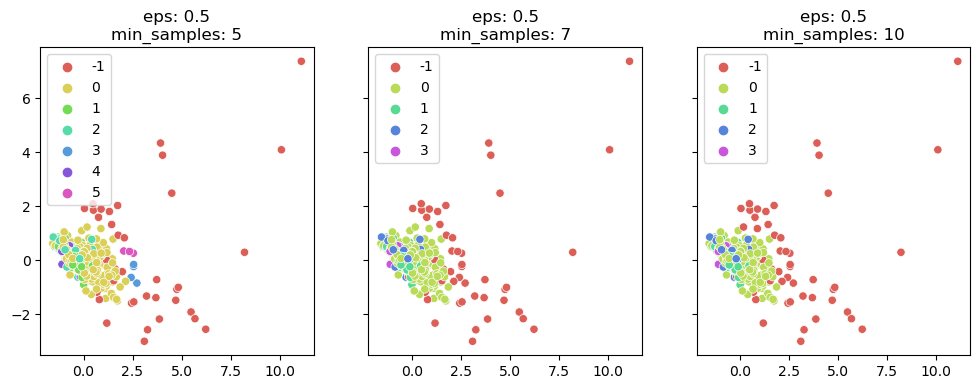

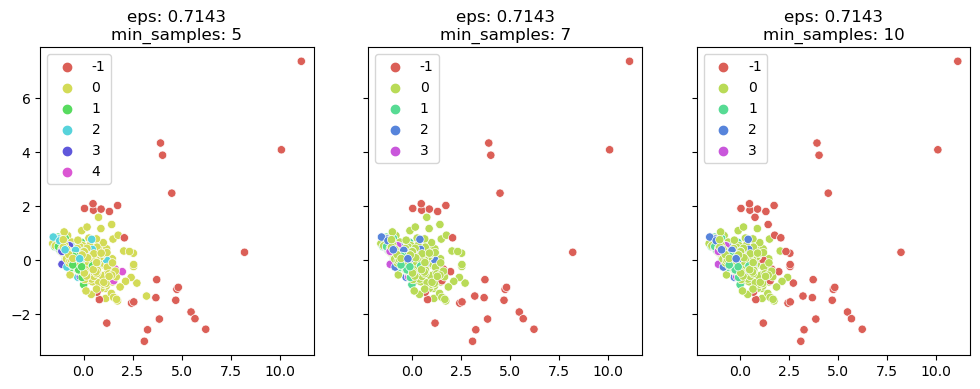

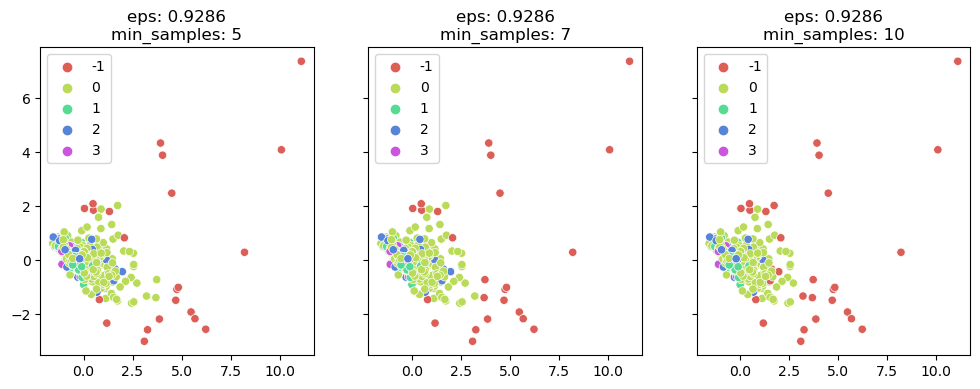

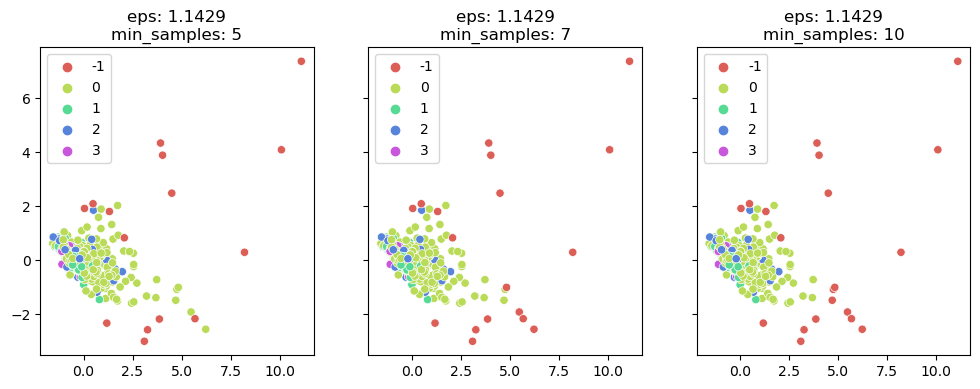

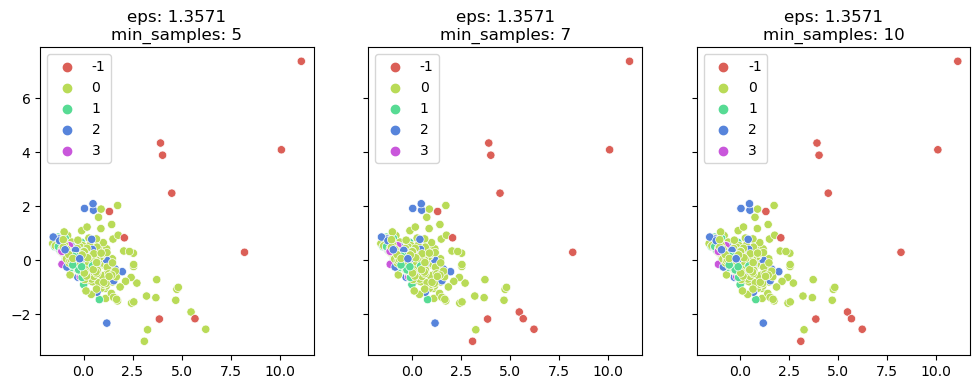

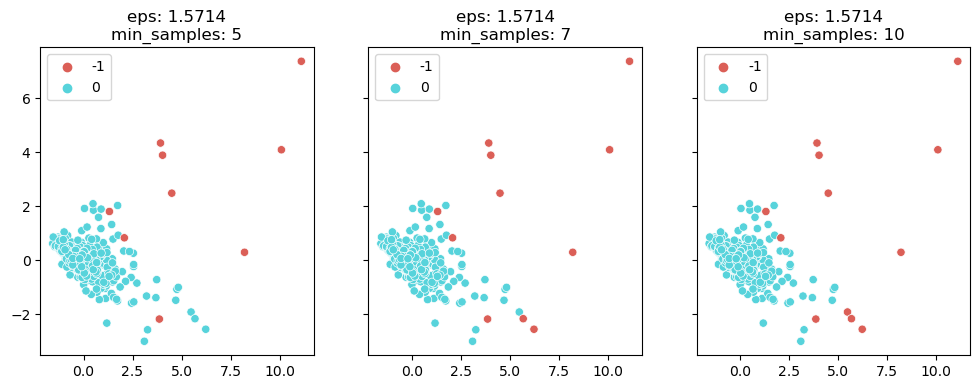

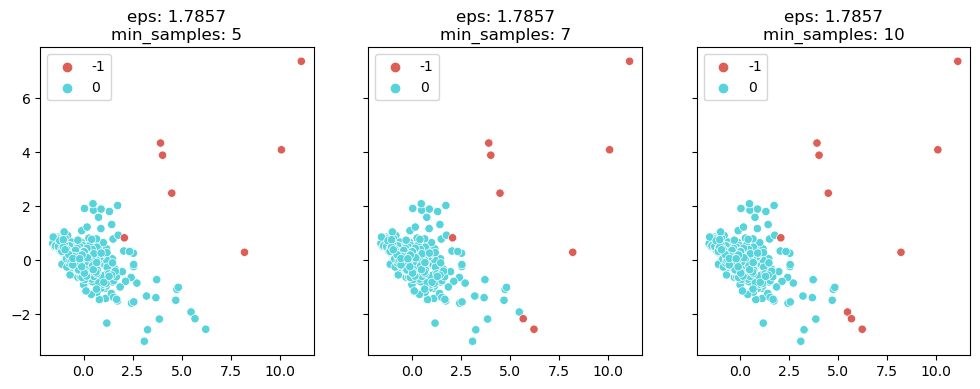

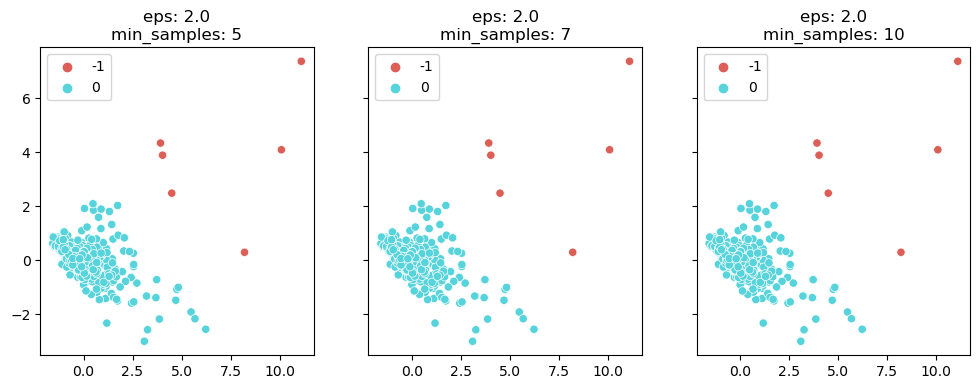

CPU times: user 1.7 s, sys: 35.4 ms, total: 1.74 s
Wall time: 1.74 s


In [137]:
%%time

# DBSCAN с использованием One-hot Encoder для кодирования категориальных признаков и расстояния Евклида

for e in eps_range_euclidean:
    f, axes = plt.subplots(1, len(min_samples_range), sharey=True,  figsize=(12, 4)) 
    i = 0
    for ms in min_samples_range:
        clust = form_strat_cluster(df_ohe, algo='DBSCAN', eps=e, min_samples=ms, metric = "euclidean")
        
        sns.scatterplot(x=X_new[:,0], y=X_new[:,1], hue=clust.labels_,\
                        palette=sns.color_palette("hls", len(np.unique(clust.labels_))), ax=axes[i])
        axes[i].set_title(f'eps: {round(e, 4)}\nmin_samples: {ms}')
        i += 1
    plt.show()

### K-means

J. Hartigan and M. Wong  "A k-means clustering algorithm."

In [138]:
n_clusters_range = range(2, 7)
list(n_clusters_range)

[2, 3, 4, 5, 6]

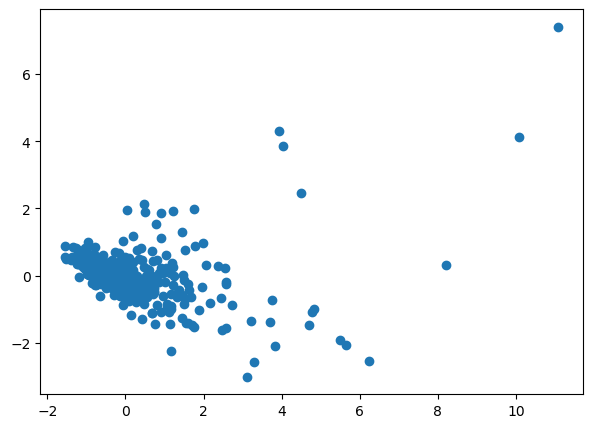

In [139]:
# Применим алгоритм понижаения размерности PCA для отрисовки данных

pca =  PCA(n_components=2)
X_new = pca.fit_transform(df_ohe)
X_new.shape
plt.scatter(X_new[:,0], X_new[:,1])

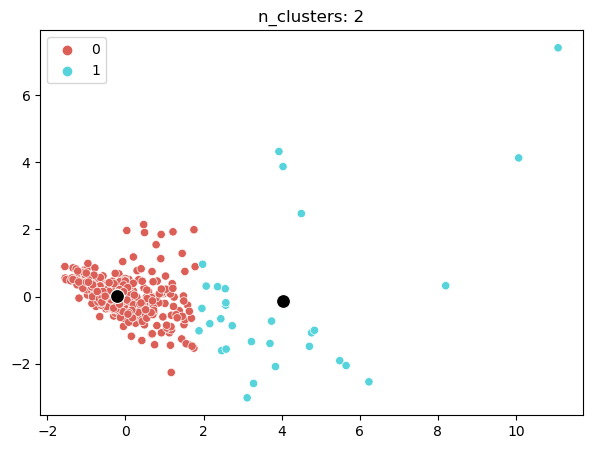

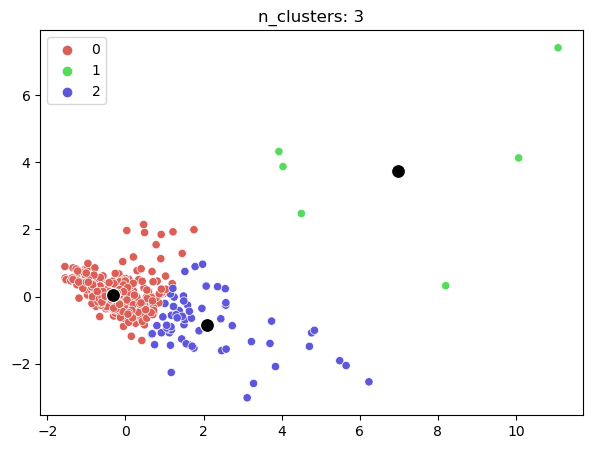

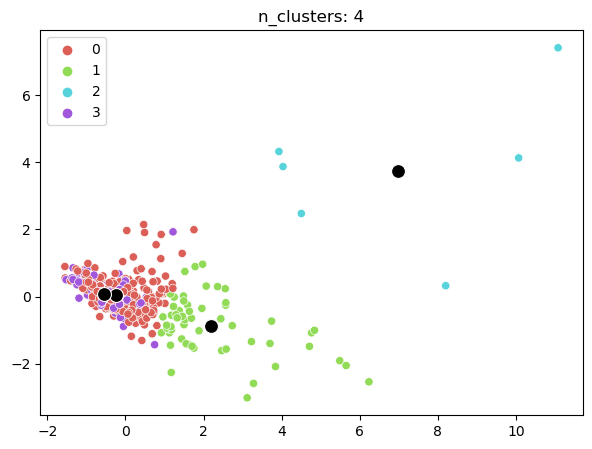

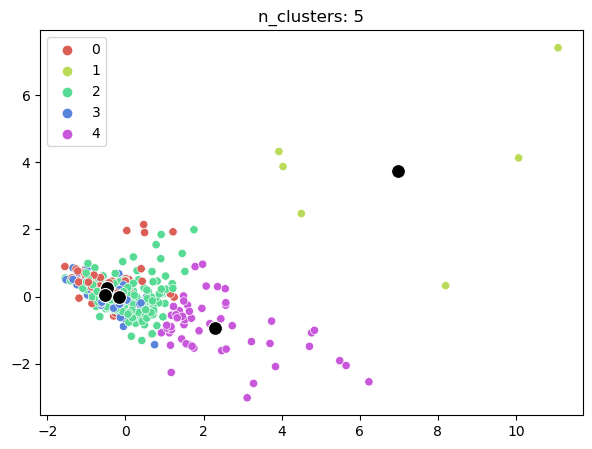

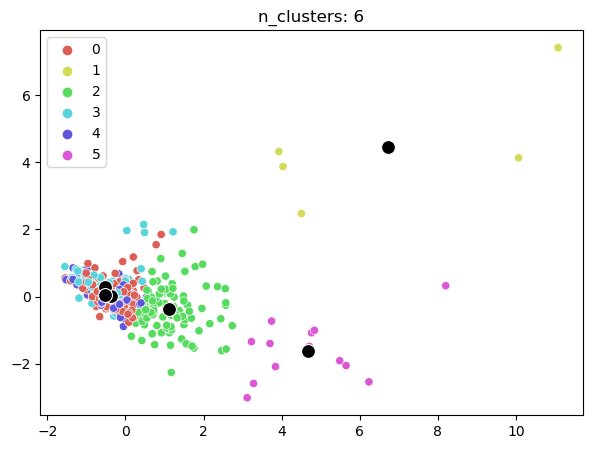

CPU times: user 558 ms, sys: 32.1 ms, total: 590 ms
Wall time: 613 ms


In [140]:
%%time

# K-Means с использованием One-hot Encoder для кодирования категориальных признаков и Standard Scaler

for nc in n_clusters_range:
    clust = form_strat_cluster(df_ohe, algo='KMeans', n_clusters=nc)
    
    centers = pca.transform(clust.cluster_centers_)
    sns.scatterplot(x=X_new[:,0] , y=X_new[:,1] , hue=clust.labels_,\
                    palette=sns.color_palette("hls", len(np.unique(clust.labels_))))
    sns.scatterplot(x=centers[:,0], y=centers[:,1] , color='black', s=100)
    plt.title(f'n_clusters: {nc}')
    plt.show()

# Черным цветом выделены центроиды кластеров

### K-prototypes

Z. Huang, "Extensions to the k-means algorithm for clustering large data sets with categorical values"

(601, 2)


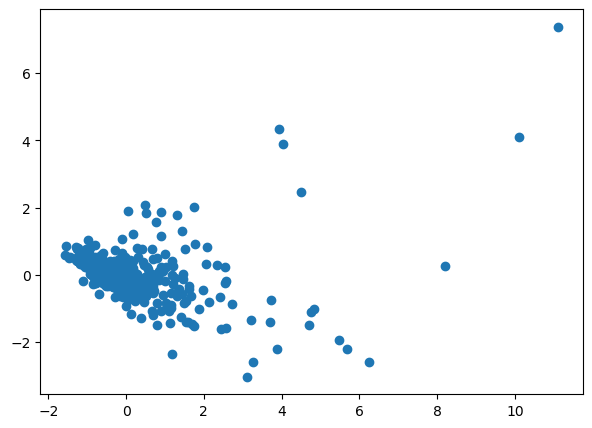

In [141]:
# Применим алгоритм понижаения размерности PCA для отрисовки данных

pca = PCA(n_components=2).fit(df_orig)

X_new = pca.transform(df_orig)
print(X_new.shape)
plt.scatter(X_new[:,0], X_new[:,1])

In [142]:
n_clusters_range = range(2, 10)
list(n_clusters_range)

[2, 3, 4, 5, 6, 7, 8, 9]

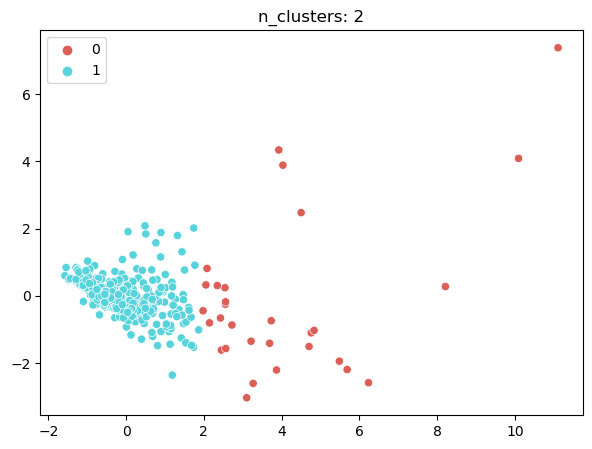

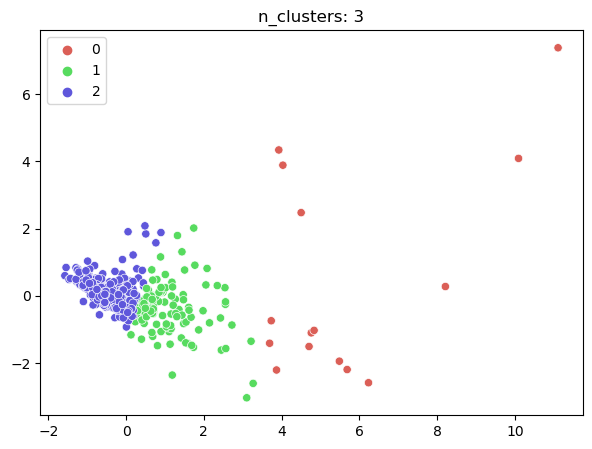

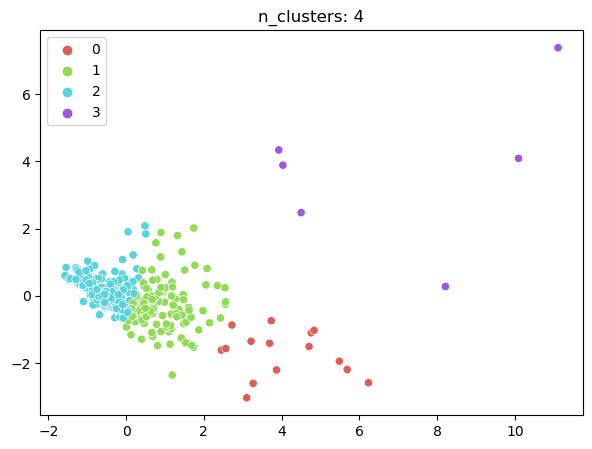

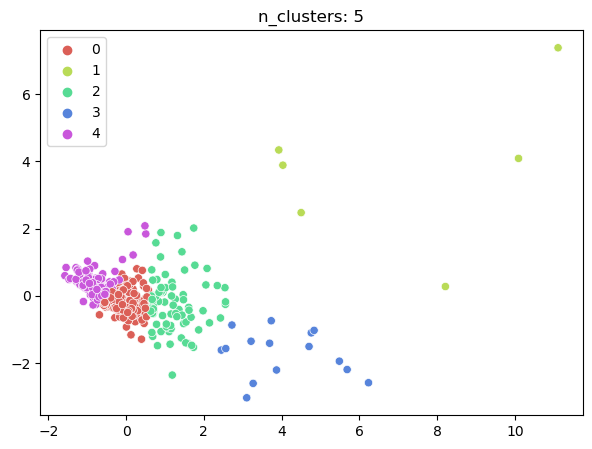

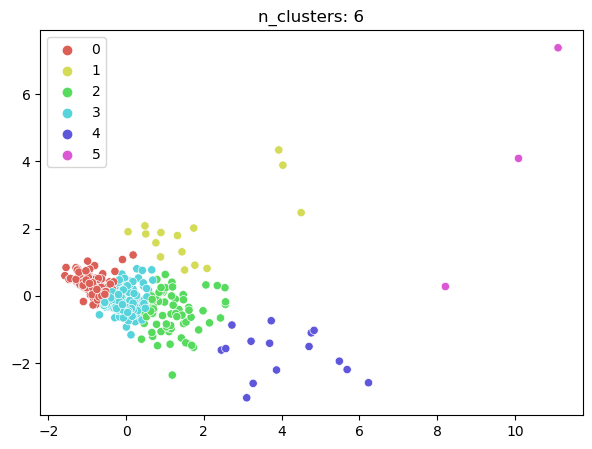

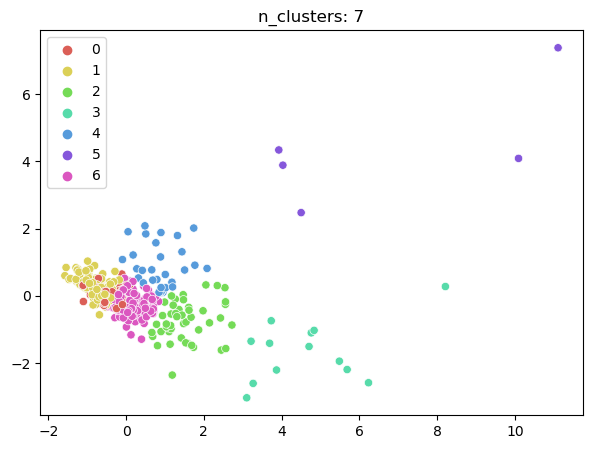

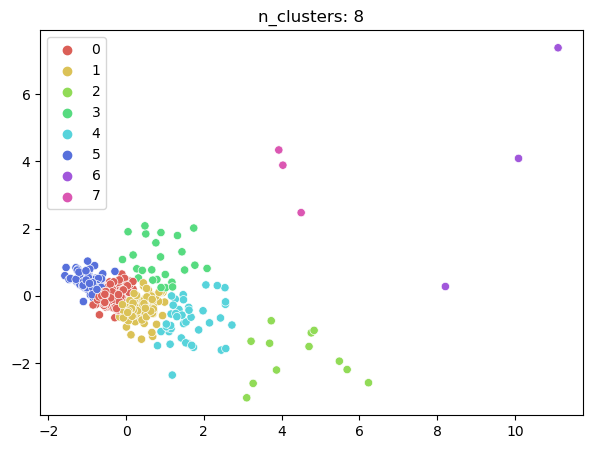

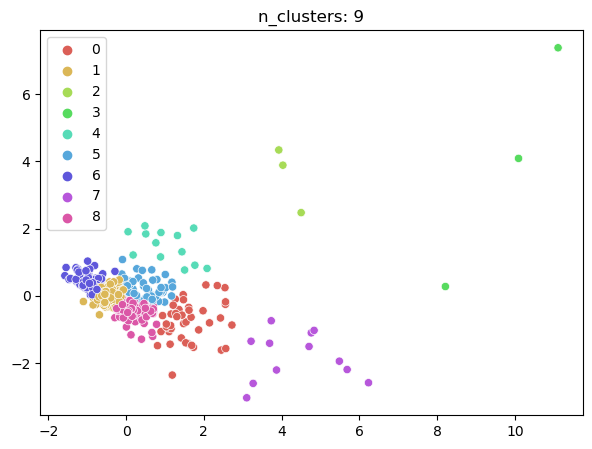

CPU times: user 26.1 s, sys: 193 ms, total: 26.3 s
Wall time: 26.5 s


In [143]:
%%time 

# K-prototype с использованием Standard Scaler

for nc in n_clusters_range:
    clust = KPrototypes(n_clusters=nc, init='Huang', gamma=0.3)
    clusters = clust.fit_predict(df_orig, categorical=[0,1])
    
    sns.scatterplot(x=X_new[:,0] , y=X_new[:,1] , hue=clust.labels_,\
                    palette=sns.color_palette("hls", len(np.unique(clust.labels_))))
    
    plt.title(f'n_clusters: {nc}')
    plt.show()


### Итог

Опираясь на приведенные выше изображения, можно сделать вывод, что метод K prototypes подходит для данного датасета лучше всего.

## Сравнение стратифицированной дисперсии при использовании разных подходов к стартификации

In [144]:
def get_strats_with_clusters(df, p_key, part = 2, strat_sample='orig', **kwargs):  
    """
    Функция для стратификации либо на основе квантильного разбиения либо на основе алгоримтов кластеризации

    Параметры:
        df - DataFrame - таблица с данными
        p_key - str - название колонки с уникальным идентификатором объекта
        part - int - число групп в A/B тесте 
        strat_sample - str - тип стратификации. Если 'orig', то проводится стратификация на основе квантильного разбиения
        **kwargs - dict - параметры для алгоритма кластеризации
    Выход:
        df - DataFrame - таблица с данными
        form_strat_ - dict - словарь с разбиением на страты
    """

    # Сортируем фичи по типу, чистим данные
    df = sorting_features(df_res = df, p_key = p_key)

    if strat_sample == 'orig':
        # Формирование страт на основе квантильного разбиения
        form_strat_ = form_strat(df, part) 
    else:
        # Формирование страт на основе алгоритмов кластеризации
        clust_algorithm = KPrototypes(**kwargs)
        categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        standart_scaller = StandardScaler()

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, ['Gender : xi2', 'Education : xi2']),
                ("num", standart_scaller, ['ApplicantIncome : ks',  'LoanAmount : ks']),
            ],
            #verbose_feature_names_out=False,
        )

        pipe = Pipeline(
            [
                ("preprocess", preprocessing),
            ]
        )
        df_ohe = pipe.fit_transform(df)
        df_orig = df_ohe[:, [1, 3, 4, 5]]
        
        clusters = clust_algorithm.fit_predict(df_orig, categorical=[0, 1])

        df['strata'] = clusters
        form_strat_ = df.groupby('strata').groups 

    return df, form_strat_ 


In [145]:
df_inp = df[['ID'] + strat_features]
df_aa = df[['ID', 'Loan_Status']]

In [146]:
TOTAL_SIZE = df_inp.shape[0]
P_KEY = "ID"
TARGET_COLUMN = "Loan_Status"

def calc_variance(values, N_h, n_h):
    """
    Функция для подсчета дисперсии по формуле Горвица-Томпсона внутри одной страты
    Параметры:
        values - array - массив со значениями целевой метрики для данной страты
        N_h - int - размер данной страты
        n_h - int - число элементов для сэмплирования
    Выход:
        var - float - дисперсия Горвица-Томпсона внутри данной страты
    """
    var = 0
    if len(values) > 1:
        var = values.var(ddof=1)
    else:
        return var
    
    if n_h != 0:
        var = N_h ** 2 * (1 - n_h / N_h) * (var / n_h)
    else:
        var = 0
    return var

def calc_strats_var_size(all_strats, target_df):
    """
    Функция для подсчета дисперсии внутри страт и размеров страт

    Параметры:
        all_strats - dict - словарь со стратами и ID пользователей
        target_df - DataFrame - таблица со значением целевой метрики для всех пользователей и их ID
    Выход:
        stds - array[float] - дисперсия каждой страты
        sizes - array[int] -  размер каждой страты
    """
    stds = []
    sizes = []

    for strata in all_strats:
        user_indexes = all_strats[strata]
        target = target_df.loc[target_df[P_KEY].isin(user_indexes), TARGET_COLUMN]
        if len(target) <= 1:
            stds.append(0.0)
        else:
            stds.append(np.std(target, ddof=1))

        sizes.append(len(target))
        
    sizes =  np.array(sizes)
    stds = np.array(stds)

    return stds, sizes

In [147]:
df_res_clust, strats_clust = get_strats_with_clusters(df_inp, p_key="ID", part=2, strat_sample='not_orig', n_clusters=9, init='Huang', gamma=0.3)
df_res_orig, strats_orig =  get_strats_with_clusters(df_inp, p_key="ID", part=2, strat_sample='orig')

In [148]:
n = 90
TOTAL_SIZE = df_inp.shape[0]

stds_orig, sizes_orig = calc_strats_var_size(strats_orig, df_aa)
n_h_orig = np.round((sizes_orig * stds_orig * n) / np.sum(stds_orig * sizes_orig)).astype(int)

stds_clust, sizes_clust = calc_strats_var_size(strats_clust, df_aa)
n_h_clust = np.round((sizes_clust * stds_clust * n) / np.sum(stds_clust * sizes_clust)).astype(int)

j = 0
var_orig = 0
var_clust = 0

for strata in strats_orig:
    all_users_from_strata = strats_orig[strata]
    np.random.seed(4) 
    users = np.random.choice(all_users_from_strata,  n_h_orig[j], replace=False)
    N_h = len(all_users_from_strata)
    var_orig += calc_variance(df_aa.loc[users, "Loan_Status"], N_h, n_h=n_h_orig[j])
    j += 1
    
j = 0
for strata in strats_clust:
    all_users_from_strata = strats_clust[strata]
    np.random.seed(4)
    users = np.random.choice(all_users_from_strata,  n_h_clust[j], replace=False)
    N_h = len(all_users_from_strata)
    var_clust += calc_variance(df_aa.loc[users, "Loan_Status"], N_h, n_h=n_h_clust[j])
    j += 1

In [149]:
data  = [[var_orig / (TOTAL_SIZE ** 2), len(strats_orig.keys())], [var_clust / (TOTAL_SIZE ** 2), 9]]

a = pd.DataFrame(data, index=['Квантильное разбиение', 'Алгоритмы кластеризации'], columns=['Стратифицированная дисперсия', 'Число страт'])
a.index.name = "Разбиение на страты"
a

,Стратифицированная дисперсия,Число страт
Разбиение на страты,,
Квантильное разбиение,0.002116,18
Алгоритмы кластеризации,0.001887,9
